In [2]:
import os
import csv
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [17]:
# helper functions

def series_append(series, list, keys):
    for i in range(64):
        series[keys[i]].append(float(list[i]))
    return series

def load_series(filename):
    with open(filename, 'r') as csv_in:
        csv_file = list(csv.reader(csv_in))
        series = {}
        keys = csv_file[0]
        for key in keys: series[key] = []
        for i in range(2, len(csv_file), 2):
            series = series_append(series, csv_file[i], keys)
        return [series, int((len(csv_file) - 2) / 2)]

def unroll(series):
    l = []
    for key in series:
        if (key[-1] == 'v' or key[-1] == 'z'): continue
        l += (series[key])
    return l

def sparse_output(filename):
    o_index = int(filename[4])
    f_index = int(filename[7])
    b_index = int(filename[10])
    s_index = int(filename[13])
    l_index = int(filename[16])
    output = [0.0] * 50
    output[o_index] = 1
    output[f_index + 10] = 1.0
    output[b_index + 20] = 1.0
    output[s_index + 30] = 1.0
    output[l_index + 40] = 1.0
    return output

def E3(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 3):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E2(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 2):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E1(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) <= 1):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

def E0(pred, truth):
    num_correct = 0
    for i in range(len(pred)):
        if (abs(pred[i] - truth[i]) == 0):
            num_correct += 1
    return (100.0 * float(num_correct) / float(len(pred)))

In [18]:
# loading data

X_train_list = []
y_train_list = []

X_test_list = []
y_test_list = []

with open("..\\test_examples.txt") as t:
    test_examples = t.readlines()

for example in test_examples:
    series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])
    x_example = unroll(series)
    y_example = sparse_output(example)
    X_test_list.append(x_example)
    y_test_list.append(y_example)

X_test = torch.tensor(X_test_list)
y_test = torch.tensor(y_test_list)
print(X_test.size())
print(y_test.size())

with open("..\\training_examples.txt") as t:
    training_examples = t.readlines()

for example in training_examples:
    series, num_frames = load_series("..\\time_series\\Time_normalized_stages\\4_final\\" + example[:-1])
    x_example = unroll(series)
    y_example = sparse_output(example)
    X_train_list.append(x_example)
    y_train_list.append(y_example)

X_train = torch.tensor(X_train_list)
y_train = torch.tensor(y_train_list)
print(X_train.size())
print(y_train.size())

torch.Size([93, 224])
torch.Size([93, 50])
torch.Size([371, 224])
torch.Size([371, 50])


In [27]:
# setting up FCNN

input_size = 224
hidden_layer_size_1 = 450
hidden_layer_size_2 = 420
hidden_layer_size_3 = 350
hidden_layer_size_4 = 270
hidden_layer_size_5 = 150
hidden_layer_size_6 = 100
output_size = 50
batch_size = 371
learning_rate = 0.00005

adam_model = nn.Sequential(nn.Linear(input_size, hidden_layer_size_1),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_1, hidden_layer_size_2),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_2, hidden_layer_size_3),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_3, hidden_layer_size_4),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_4, hidden_layer_size_5),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_5, hidden_layer_size_6),
                        nn.ReLU(),
                        nn.Linear(hidden_layer_size_6, output_size),
                        nn.Sigmoid())

loss_function = nn.MSELoss()
optimizer = torch.optim.AdamW(adam_model.parameters(), lr=learning_rate)

Text(0.5, 0, 'Epoch')

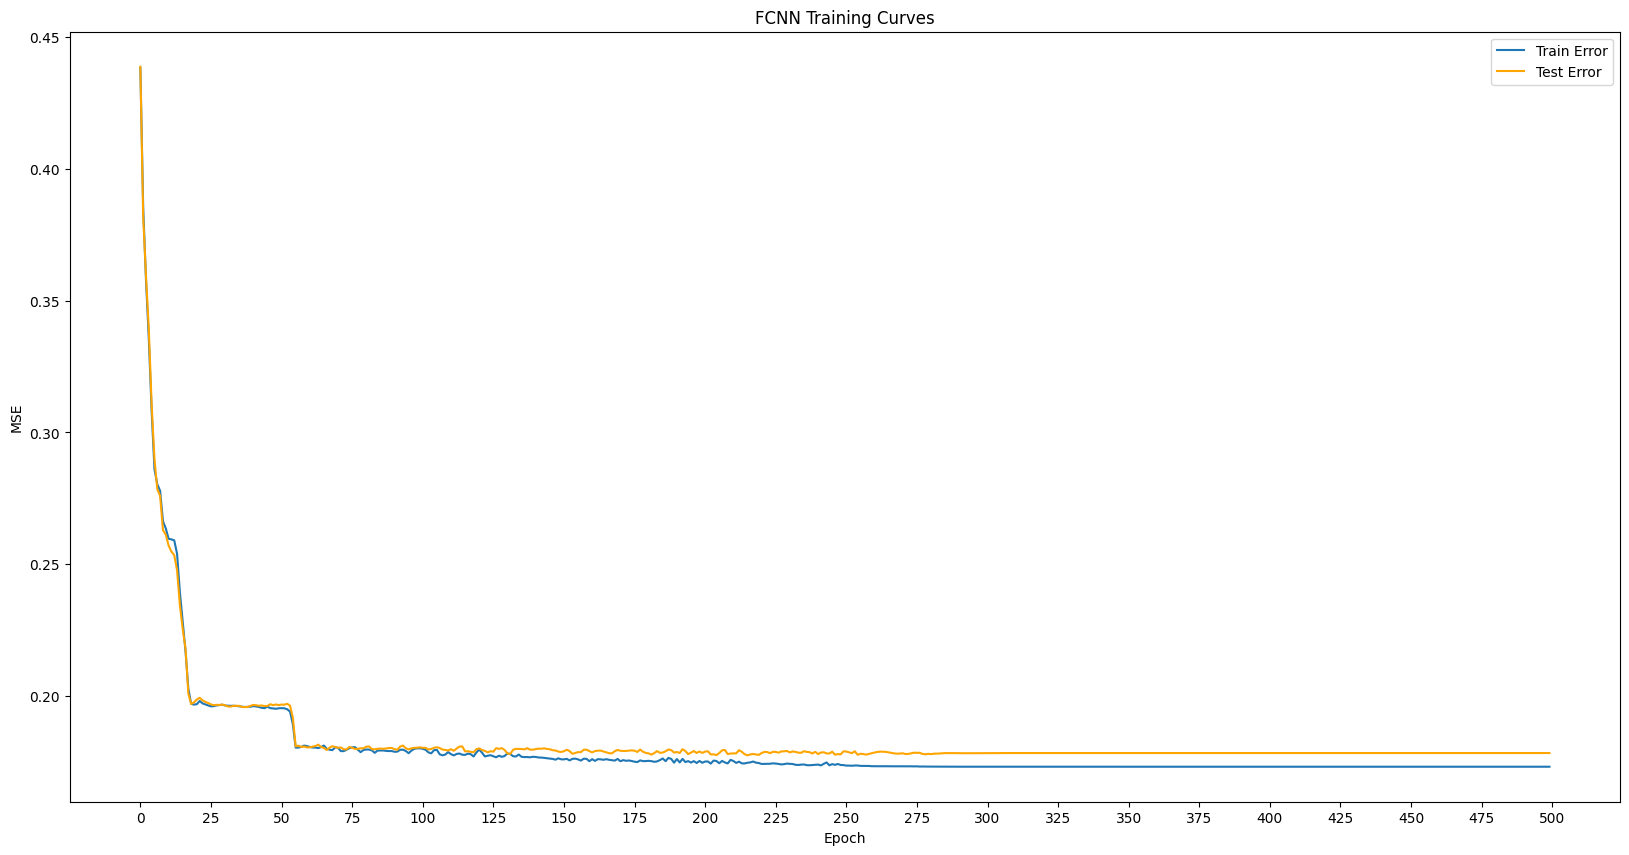

In [35]:
# model training

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

min_loss = 1.0
num_epochs = 500

adam_model.apply(init_weights)

#while(min_loss > 0.15):
losses = []
test_losses = []
for epoch in range(num_epochs):
    pred_y = adam_model(X_train)
    loss = loss_function(pred_y, y_train)
    losses.append(loss.item())

    test_y = adam_model(X_test)
    test_loss = loss_function(test_y, y_test)
    test_losses.append(test_loss.item())

    adam_model.zero_grad()
    loss.backward()

    optimizer.step()

min_loss = min(test_losses)

fig, ax = plt.subplots(1, figsize=(20, 10))

ax.plot(losses, label="Train Error")
ax.plot(test_losses, label="Test Error", c="orange")
ax.set_title("FCNN Training Curves")
ax.legend()
ax.set_xticks(np.linspace(0, num_epochs, num=21))

ax.set_ylabel("MSE")
ax.set_xlabel("Epoch")

In [25]:
o_pred = []
f_pred = []
b_pred = []
s_pred = []
l_pred = []

o_truth = []
f_truth = []
b_truth = []
s_truth = []
l_truth = []

y_pred = adam_model(X_test)

print(y_pred)

tensor([[9.0775e-11, 0.0000e+00, 1.0000e+00,  ..., 0.0000e+00, 1.0000e+00,
         1.0000e+00],
        [1.1507e-11, 9.9999e-01, 1.0000e+00,  ..., 2.0095e-38, 1.0000e+00,
         1.0000e+00],
        [1.0238e-24, 1.5070e-09, 1.0000e+00,  ..., 7.6753e-37, 1.0000e+00,
         1.0000e+00],
        ...,
        [3.8050e-18, 0.0000e+00, 1.0000e+00,  ..., 4.8044e-21, 1.0000e+00,
         1.0000e+00],
        [3.1513e-34, 1.2278e-08, 1.0000e+00,  ..., 3.3326e-17, 1.0000e+00,
         1.0000e+00],
        [1.7247e-30, 1.4335e-25, 1.0000e+00,  ..., 1.2806e-32, 1.0000e+00,
         1.0000e+00]], grad_fn=<SigmoidBackward0>)
